[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Object Localization

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 08/06/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0098DeepLearningObjectLocalization.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.detection.iou import IntersectionOverUnion

import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Miscellaneous
import copy
from enum import auto, Enum, unique
import math
import os
from platform import python_version
import random
import shutil
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

2024-06-15 04:40:45.389639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_SET_FILE_NAME      = 'archive.zip'
DATA_SET_FOLDER_NAME    = 'IntelImgCls'

D_CLASSES  = {0: 'Red', 1: 'Green', 2: 'Blue'}
L_CLASSES  = ['R', 'G', 'B']
T_IMG_SIZE = (100, 100, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('../../utils')
sys.path.append('/home/vlad/utils')
from DataManipulation import BBoxFormat
from DataManipulation import GenLabeldEllipseImg
from DataVisualization import PlotBox, PlotBBox, PlotLabelsHistogram
from DeepLearningPyTorch import ObjectLocalizationDataset
from DeepLearningPyTorch import GenDataLoaders, InitWeightsKaiNorm, TrainModel, TrainModelSch


* <font color='blue'>(**!**)</font> Go through `GenLabeldDataEllipse()`.
* <font color='blue'>(**!**)</font> Go through `ObjectLocalizationDataset`.

In [6]:
# General Auxiliary Functions

def GenResNetModel( trainedModel: bool, numCls: int, resNetDepth: int = 18 ) -> nn.Module:
    # Read on the API change at: How to Train State of the Art Models Using TorchVision’s Latest Primitives
    # https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives

    if (resNetDepth == 18):
        modelFun = torchvision.models.resnet18
        modelWeights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    elif (resNetDepth == 34):
        modelFun = torchvision.models.resnet34
        modelWeights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1
    else:
        raise ValueError(f'The `resNetDepth`: {resNetDepth} is invalid!')

    if trainedModel:
        oModel = modelFun(weights = modelWeights)
        numFeaturesIn   = oModel.fc.in_features
        # Assuming numCls << 100
        oModel.fc       = nn.Sequential(
            nn.Linear(numFeaturesIn, 128), nn.ReLU(),
            nn.Linear(128, numCls),
        )
    else:
        oModel = modelFun(weights = None, num_classes = numCls)

    return oModel


def GenData( numSamples: int, tuImgSize: Tuple[int, int, int], boxFormat: BBoxFormat = BBoxFormat.YOLO ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    mX = np.empty(shape = (numSamples, *tuImgSize[::-1]))
    vY = np.empty(shape = numSamples, dtype = np.int_)
    mB = np.empty(shape = (numSamples, 4))

    for ii in range(numSamples):
        mI, vLbl, mBB = GenLabeldEllipseImg(tuImgSize[:2], 1, boxFormat = boxFormat)
        mX[ii]  = np.transpose(mI, (2, 0, 1))
        vY[ii]  = vLbl[0]
        mB[ii]  = mBB[0]
    
    return mX, vY, mB
        
# Data Loader
# Using a function to mitigate Multi Process issues:
# https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection
def DataLoaderBatch( dlData: DataLoader ) -> Tuple:
    
    return next(iter(dlData)) #<! PyTorch Tensors


## Object Localization

The composability of _Deep Learning_ loss allows combining 2 tasks into 1.  
_Object Localization_ is a composition of 2 tasks:

 - Classification: Identify the object class.
 - Regression: Localize the object by a _Bounding Box_ (BB).

This notebook demonstrates:
 - Generating a synthetic data set.
 - Building a model for _object localization_
 - Training a model with a composed objective.

</br>

* <font color='brown'>(**#**)</font> In the notebook context _Object Localization_ assumes the existence of an object in the image and only a single object.
* <font color='brown'>(**#**)</font> In the notebook context _Object Detection_ generalizes the task to support the case of non existence or several objects.
* <font color='brown'>(**#**)</font> The motivation for a synthetic dataset is being able to implement the whole training process (Existing datasets are huge).  
  Yet the ability to create synthetic dataset is a useful skill.
* <font color='brown'>(**#**)</font> There are known datasets for object detection: [COCO Dataset](https://cocodataset.org), [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).   
  They also define standards for the labeling system.  
  Training them is on the scale of days.
* <font color='brown'>(**#**)</font> [Object Detection Annotation Formats](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation).

In [7]:
# Parameters

# Data
numSamplesTrain = 30_000
numSamplesVal   = 10_000
boxFormat       = BBoxFormat.YOLO

# Model
dropP = 0.5 #<! Dropout Layer

# Training
batchSize   = 256
numWorkers  = 2 #<! Number of workers
numEpochs   = 35
λ = 20.0 #<! Localization Loss
ϵ = 0.1 #<! Label Smoothing

# Visualization
numImg = 3


## Generate / Load Data

The data is synthetic data.  
Each image includes and Ellipse where its color is the class (`R`, `G`, `B`) and the bounding rectangle.

* <font color='brown'>(**#**)</font> The label is a vector of `5`: `[Class, xCenter, yCenter, boxWidth, boxHeight]`.  
* <font color='brown'>(**#**)</font> The label is in `YOLO` format, hence it is normalized to `[0, 1]`.


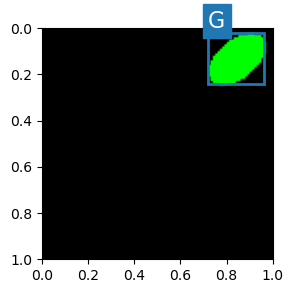

In [8]:
# Image Sample

mI, vY, mBB = GenLabeldEllipseImg(T_IMG_SIZE[:2], 1, boxFormat = boxFormat)
vBox = mBB[0] #<! Matrix to support multiple objects in a single image
clsIdx = vY[0]
hA = PlotBox(mI, L_CLASSES[clsIdx], vBox)

* <font color='brown'>(**#**)</font> One could use negative values for the bounding box. The model will extrapolate the object dimensions.

In [9]:
## reduce to test
numSamplesTrain = 3_000
numSamplesVal   = 1_000

In [10]:
# Generate Data

mXTrain, vYTrain, mBBTrain = GenData(numSamplesTrain, T_IMG_SIZE, boxFormat = boxFormat)
mXVal,   vYVal,   mBBVal   = GenData(numSamplesVal, T_IMG_SIZE, boxFormat = boxFormat)

print(f'The training data set data shape: {mXTrain.shape}')
print(f'The training data set labels shape: {vYTrain.shape}')
print(f'The training data set box shape: {mBBTrain.shape}')
print(f'The validation data set data shape: {mXVal.shape}')
print(f'The validation data set labels shape: {vYTrain.shape}')
print(f'The validation data set box shape: {mBBVal.shape}')

The training data set data shape: (3000, 3, 100, 100)
The training data set labels shape: (3000,)
The training data set box shape: (3000, 4)
The validation data set data shape: (1000, 3, 100, 100)
The validation data set labels shape: (3000,)
The validation data set box shape: (1000, 4)


In [11]:
# Generate Data

dsTrain = ObjectLocalizationDataset(mXTrain, vYTrain, mBBTrain)
dsVal   = ObjectLocalizationDataset(mXVal, vYVal, mBBVal)
lClass  = list(dsTrain.vY)

print(f'The training data set data shape: {dsTrain.tX.shape}')
print(f'The test data set data shape: {dsVal.tX.shape}')
print(f'The unique values of the labels: {np.unique(lClass)}')

The training data set data shape: (3000, 3, 100, 100)
The test data set data shape: (1000, 3, 100, 100)
The unique values of the labels: [0 1 2]


* <font color='brown'>(**#**)</font> PyTorch with the `v2` transforms deals with bounding boxes using special type: `BoundingBoxes`.
* <font color='brown'>(**#**)</font> For _data augmentation_ see:
    - [Transforming and Augmenting Images](https://pytorch.org/vision/stable/transforms.html).
    - [Getting Started with Transforms v2](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html).
    - [Transforms v2: End to End Object Detection / Segmentation Example](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_e2e.html).
    - [How to Write Your Own v2 Transforms](https://pytorch.org/vision/stable/auto_examples/transforms/plot_custom_transforms.html).

In [12]:
# Element of the Data Set

mX, vY = dsTrain[0]

valY    = int(vY[0])
vB      = vY[1:]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')
print(f'The bounding box value: {vB}')

The features shape: (3, 100, 100)
The label value: 0
The bounding box value: [0.175 0.8   0.35  0.36 ]


* <font color='brown'>(**#**)</font> Since the labels are in the same contiguous container as the bounding box parameters, their type is `Float`.
* <font color='brown'>(**#**)</font> The bounding box is using absolute values. In practice it is commonly normalized to the image dimensions.

### Plot the Data

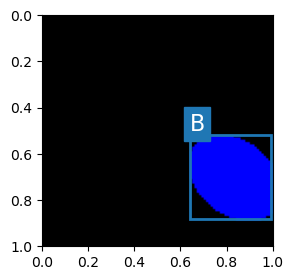

In [33]:
# Plot the Data

hA = PlotBox(np.transpose(mX, (1, 2, 0)), L_CLASSES[valY], vB)


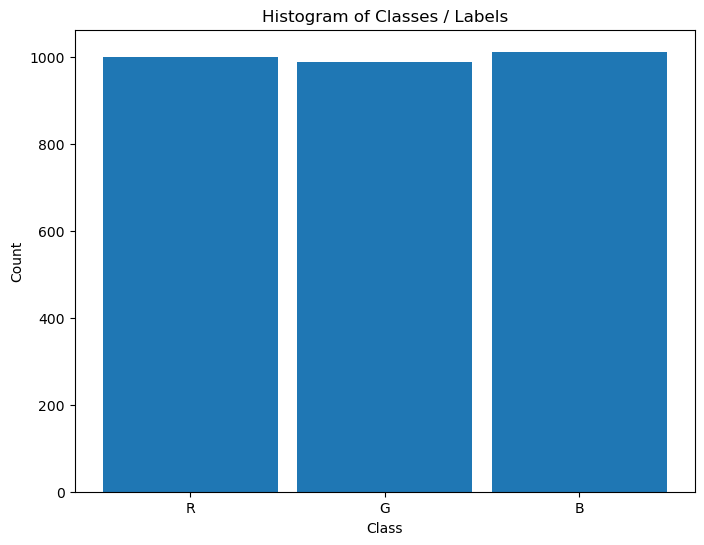

In [14]:
# Histogram of Labels

hA = PlotLabelsHistogram(dsTrain.vY, lClass = L_CLASSES)
plt.show()

### Data Loaders

This section defines the data loaded.



In [15]:
# Data Loader

dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWorkers, drop_last = True, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = numWorkers, persistent_workers = True)

# dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = 0, drop_last = True, persistent_workers = False)
# dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = 0, persistent_workers = False)


In [16]:
# Iterate on the Loader
# The first batch.

tX, mY = DataLoaderBatch(dlTrain)

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {mY[:, 0].shape}')
print(f'The batch bounding box dimensions: {mY[:, 1:].shape}')

The batch features dimensions: torch.Size([256, 3, 100, 100])
The batch labels dimensions: torch.Size([256])
The batch bounding box dimensions: torch.Size([256, 4])


## The Model

This section defines the model.  

* <font color='brown'>(**#**)</font> The following implementation has a model with a single output, both for the regression and the classification.
* <font color='brown'>(**#**)</font> One could create 2 different outputs (_Heads_) for each task.

In [17]:
# Model
# Model generating function.

def BuildModel( numCls: int ) -> nn.Module:

    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3,   32,  3, stride = 2, padding = 0, bias = False), nn.BatchNorm2d(32 ), nn.ReLU(),
        nn.Conv2d(32,  32,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(32 ), nn.ReLU(),
        nn.Conv2d(32,  32,  3, stride = 2, padding = 0, bias = False), nn.BatchNorm2d(32 ), nn.ReLU(),
        nn.Conv2d(32,  32,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(32 ), nn.ReLU(),
        nn.Conv2d(32,  32,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(32 ), nn.ReLU(),
        nn.Conv2d(32,  64,  3, stride = 2, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  64,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  64,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  64,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  64,  3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  64,  3, stride = 2, padding = 1, bias = False), nn.BatchNorm2d(64 ), nn.ReLU(),
        nn.Conv2d(64,  128, 3, stride = 1, padding = 0, bias = False), nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 256, 3, stride = 1, padding = 0, bias = False), nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(256, 512, 2, stride = 1, padding = 0, bias = False), nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(512, numCls + 4, 1, stride = 1, padding = 0, bias = True),
        nn.Flatten()
    )

    return oModel 

## notes 

(1) instead of fully connected at the end - we have a single output - with 1x1 pixel;
* end of 1x1 pixel is like seeing in receptive field all the input image;

```

nn.Conv2d(512, numCls + 4, 1, stride = 1, padding = 0, bias = True),
nn.Flatten()

├─Conv2d (43): 1-44                      [1, 1]                    [256, 7, 1, 1]            3,591

    convulsion 1*1 - 7 times

├─Flatten (44): 1-45                     --                        [256, 7]                  --

****   it the same like linear FC =>  512 * 7 + 7  = 3591

```
(2) why so deep and so many layers?
* for RF to include all the ellipse ; each pixel at the end must know if he inside the ellipse
* calc RF ?


(3) used input of 100x100 can do the same for other size input?
* input of 20x20 cant - less then 100x100 cant go to 1x1...
* 120x120 can work but wont finish with 1x1 - so need to resize and crop to 100x100

In [18]:
# Build the Model

oModel = BuildModel(len(L_CLASSES))

In [19]:
# Model Information - Pre Defined
# Pay attention to the layers name.
torchinfo.summary(oModel, (batchSize, *(T_IMG_SIZE[::-1])), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu', row_settings = ['depth', 'var_names'])

Layer (type (var_name):depth-idx)        Kernel Shape              Output Shape              Param #
Sequential (Sequential)                  --                        [256, 7]                  --
├─Identity (0): 1-1                      --                        [256, 3, 100, 100]        --
├─Conv2d (1): 1-2                        [3, 3]                    [256, 32, 49, 49]         864
├─BatchNorm2d (2): 1-3                   --                        [256, 32, 49, 49]         64
├─ReLU (3): 1-4                          --                        [256, 32, 49, 49]         --
├─Conv2d (4): 1-5                        [3, 3]                    [256, 32, 49, 49]         9,216
├─BatchNorm2d (5): 1-6                   --                        [256, 32, 49, 49]         64
├─ReLU (6): 1-7                          --                        [256, 32, 49, 49]         --
├─Conv2d (7): 1-8                        [3, 3]                    [256, 32, 24, 24]         9,216
├─BatchNorm2d (8): 1-9      

* <font color='red'>(**?**)</font> Explain the dimensions of the last layer.
* <font color='red'>(**?**)</font> Will the model work with smaller images?

## Train the Model

This section trains the model.  

* <font color='brown'>(**#**)</font> The training loop must be adapted to the new loss function.

### Image Localization Loss

The loss is a composite of 2 loss functions:

$$\ell\left(\hat{\boldsymbol{y}},\boldsymbol{y}\right)=\lambda_{\text{MSE}}\cdot\ell_{\text{MSE}}\left(\hat{\boldsymbol{y}}_{\text{bbox}},\boldsymbol{y}_{\text{bbox}}\right)+\lambda_{\text{CE}}\cdot\ell_{\text{CE}}\left(\hat{\boldsymbol{y}}_{\text{label}},\boldsymbol{y}_{\text{label}}\right)$$

Where $\lambda_{\text{MSE}}$ and $\lambda_{\text{CE}}$ are the weights of each loss.

* <font color='brown'>(**#**)</font> In practice a single $\lambda$ is required.
* <font color='brown'>(**#**)</font> The MSE is not optimal loss function. It will be replaced by the _Log Euclidean_ loss.

In [20]:
# Object Localization Loss
class ObjLocLoss( nn.Module ):
    def __init__( self, numCls: int, λ: float, ϵ: float = 0.0 ) -> None:
        super(ObjLocLoss, self).__init__()

        self.numCls     = numCls
        self.λ          = λ
        self.ϵ          = ϵ
        self.oMseLoss   = nn.MSELoss()
        self.oCeLoss    = nn.CrossEntropyLoss(label_smoothing = ϵ)
    
    def forward( self: Self, mYHat: torch.Tensor, mY: torch.Tensor ) -> torch.Tensor:

        mseLoss = self.oMseLoss(mYHat[:, self.numCls:], mY[:, 1:])
        ceLoss  = self.oCeLoss(mYHat[:, :self.numCls], mY[:, 0].to(torch.long))

        lossVal = (self.λ * mseLoss) + ceLoss
		
        return lossVal

### Image Localization Score

The score is defined by the _IoU_ of a valid classification:

$$\text{Metric}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{I}\left\{ \hat{y}_{i}=y_{i}\right\} \cdot\text{IoU}\left(\hat{B}_{i},B_{i}\right)$$

Where:
- $\hat{y}_{i}$ is the predicted label
- $y_{i}$ is the correct label
- $\hat{B}_{i}$ is the predicted bounding box
- $B_{i}$ is the correct bounding box
In other words, the average IoU, considering only correct (label) prediction.

In [21]:
# Object Localization Score
class ObjLocScore( nn.Module ):
    def __init__( self, numCls: int ) -> None:
        super(ObjLocScore, self).__init__()

        self.numCls = numCls
    
    def forward( self: Self, mYHat: torch.Tensor, mY: torch.Tensor ) -> Tuple[float, float, float]:

        batchSize = mYHat.shape[0]
        
        vY, mBox = mY[:, 0].to(torch.long), mY[:, 1:]

        vIoU = torch.diag(torchvision.ops.box_iou(torchvision.ops.box_convert(mYHat[:, self.numCls:], 'cxcywh', 'xyxy'), torchvision.ops.box_convert(mBox, 'cxcywh', 'xyxy')))
        vCor = (vY == torch.argmax(mYHat[:, :self.numCls], dim = 1)).to(torch.float32) #<! Correct labels

        # valIoU      = torch.mean(vIoU).item()
        # valAcc      = torch.mean(vCor).item()
        valScore    = torch.inner(vIoU, vCor) / batchSize
		
        return valScore

In [22]:
# Run Device

runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [23]:
# Loss and Score Function

hL = ObjLocLoss(numCls = len(L_CLASSES), λ = λ, ϵ = ϵ)
hS = ObjLocScore(numCls = len(L_CLASSES))

hL = hL.to(runDevice)
hS = hS.to(runDevice)


In [24]:
# Training Loop

oModel = oModel.to(runDevice)
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-5, betas = (0.9, 0.99), weight_decay = 1e-5) #<! Define optimizer
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-4, total_steps = numEpochs)
_, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModel(oModel, dlTrain, dlVal, oOpt, numEpochs, hL, hS, oSch = oSch)

Epoch    1 / 35 | Train Loss:  8.204 | Val Loss:  5.342 | Train Score:  0.000 | Val Score:  0.000 | Epoch Time: 14.86 | <-- Checkpoint! |
Epoch    2 / 35 | Train Loss:  6.180 | Val Loss:  4.699 | Train Score:  0.001 | Val Score:  0.000 | Epoch Time:  1.26 |
Epoch    3 / 35 | Train Loss:  3.907 | Val Loss:  2.758 | Train Score:  0.005 | Val Score:  0.002 | Epoch Time:  1.23 | <-- Checkpoint! |
Epoch    4 / 35 | Train Loss:  1.965 | Val Loss:  2.085 | Train Score:  0.070 | Val Score:  0.029 | Epoch Time:  1.23 | <-- Checkpoint! |
Epoch    5 / 35 | Train Loss:  1.393 | Val Loss:  1.573 | Train Score:  0.193 | Val Score:  0.122 | Epoch Time:  1.23 | <-- Checkpoint! |
Epoch    6 / 35 | Train Loss:  1.136 | Val Loss:  1.609 | Train Score:  0.234 | Val Score:  0.181 | Epoch Time:  1.24 | <-- Checkpoint! |
Epoch    7 / 35 | Train Loss:  0.865 | Val Loss:  0.976 | Train Score:  0.305 | Val Score:  0.265 | Epoch Time:  1.23 | <-- Checkpoint! |
Epoch    8 / 35 | Train Loss:  0.702 | Val Loss:  0.

Text(0, 0.5, 'Learn Rate')

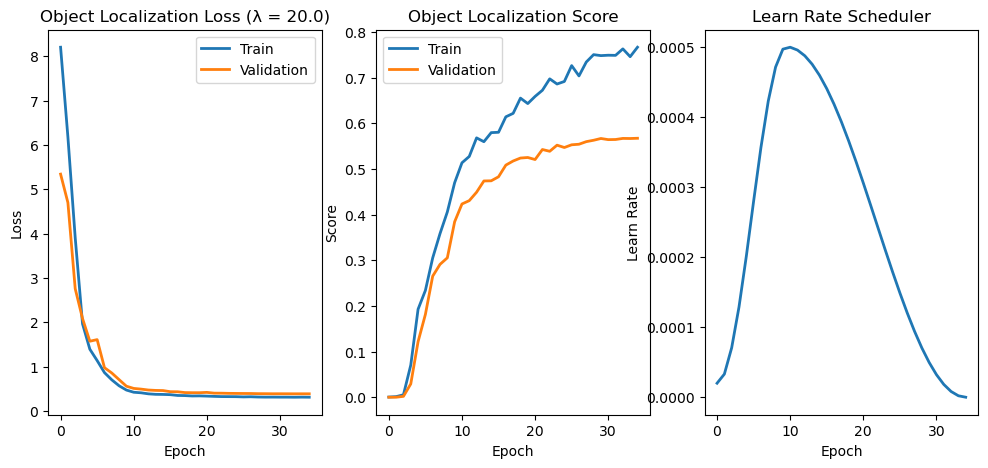

In [25]:
# Plot Training Phase

hF, vHa = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
vHa = np.ravel(vHa)

hA = vHa[0]
hA.plot(lTrainLoss, lw = 2, label = 'Train')
hA.plot(lValLoss, lw = 2, label = 'Validation')
hA.set_title(f'Object Localization Loss (λ = {λ:0.1f})')
hA.set_xlabel('Epoch')
hA.set_ylabel('Loss')
hA.legend()

hA = vHa[1]
hA.plot(lTrainScore, lw = 2, label = 'Train')
hA.plot(lValScore, lw = 2, label = 'Validation')
hA.set_title('Object Localization Score')
hA.set_xlabel('Epoch')
hA.set_ylabel('Score')
hA.legend()

hA = vHa[2]
hA.plot(lLearnRate, lw = 2)
hA.set_title('Learn Rate Scheduler')
hA.set_xlabel('Epoch')
hA.set_ylabel('Learn Rate')

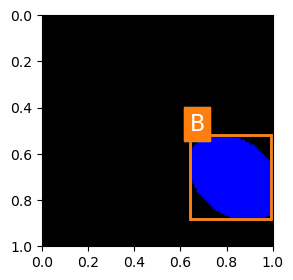

In [26]:
# Plot Prediction

rndIdx = np.random.randint(numSamplesVal)

mX, vY = dsVal[rndIdx]
valY    = int(vY[0])
vB      = vY[1:]
with torch.no_grad():
    tX = torch.tensor(mX)
    tX = torch.unsqueeze(tX, 0)
    tX = tX.to(runDevice)
    mYHat = oModel(tX).detach().cpu().numpy()

vYHat       = mYHat[0]
valYHat     = int(vYHat[0])
vBHat       = vY[1:]

hA = PlotBox(np.transpose(mX, (1, 2, 0)), L_CLASSES[valY], vB)
hA = PlotBBox(hA, L_CLASSES[valYHat], vBHat)

* <font color='green'>(**@**)</font> Display the _accuracy_ and _IoU_ scores and _MSE_ and _CE_ loss over the epochs.   
  It will require updating the Loss, Score classes and the training function.